In [1]:
import pandas as pd
import numpy as np

# Pré-processando dados

## Lendo arquivos

In [2]:
regime_df = pd.read_csv("../data/preprocessed/regime_data.csv")
crisis_df = pd.read_csv("../data/preprocessed/crisis_data.csv")

In [3]:
regime_df["country_name"] = regime_df["country_name"].str.upper()

## Gerando visão agregada em `crisis_df`

Para cada intervalo de tempo (`gov_start`, `gov_end`), geraremos as seguintes visões agregadas relativas ao banco de crises:

1. Para variáveis indicadoras: 'crisis_banking', 'crisis_systemic', 'default_domestic_debt', 'default_sovereign_debt_tp2', 'crisis_currency', 'crisis_currency'
    * **Soma** das variáveis
    * **Média ponderada**, onde o peso para o i-ésimo ano é $w_i=\frac{i}{\sum i}$
2. Para `ref_inflation`, o valor do último ano

### Encontrando os intervalos de tempo no banco de regimes:

In [4]:
intervals_df = regime_df[["gov_start", "gov_duration", "country_name", "gov_id"]]
intervals_df["gov_end"] = intervals_df["gov_start"] + intervals_df["gov_duration"]

/tmp/ipykernel_2630/1930312625.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  intervals_df["gov_end"] = intervals_df["gov_start"] + intervals_df["gov_duration"]


In [5]:
gov_id_per_row = []

for index, value in crisis_df.iterrows():

    df_ = intervals_df[intervals_df["country_name"] == value["country_name"]]
    start_interval = df_[df_["gov_start"] <= value["ref_year"]]["gov_start"].max()

    gov_id_per_row.append(
        df_[df_["gov_start"] == start_interval]["gov_id"].values
    )

In [6]:
crisis_df["gov_id"] = [x[0] if x else np.nan for x in gov_id_per_row]

/tmp/ipykernel_2630/2060908396.py:1: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  crisis_df["gov_id"] = [x[0] if x else np.nan for x in gov_id_per_row]


Mantendo apenas países que estejam no dataset de crises

In [7]:
crisis_df = crisis_df.dropna(subset="gov_id")

### Gerando as variáveis agregadas

In [8]:
indicating_cols = ['crisis_banking', 'crisis_systemic', 'default_domestic_debt', 'default_sovereign_debt_tp2', 'crisis_currency', 'crisis_currency']

In [9]:
crisis_df["pos_order"] = (
    crisis_df
    .groupby("gov_id")["ref_year"]
    .rank(method="min")
)

In [10]:
aggr_ponderado = (
    crisis_df
    .groupby("gov_id")
    .agg({"pos_order" : "sum"})
    .rename({"pos_order" : "sum_pos_order"}, axis=1)
    .merge(crisis_df, left_index=True, right_on="gov_id")
)

for col in indicating_cols:
    aggr_ponderado[col] = (aggr_ponderado[col] * aggr_ponderado["pos_order"]) / aggr_ponderado["sum_pos_order"]

aggr_ponderado = (
    aggr_ponderado    
    .groupby("gov_id")
    .agg({col : "sum" for col in indicating_cols})
    .rename({ col : f"pond_{col}" for col in indicating_cols}, axis=1)
)

In [11]:
aggr_df = crisis_df.groupby("gov_id")

In [12]:
crisis_aggr = (
    aggr_df
    .agg({ col : "sum" for col in indicating_cols})
    .merge(
        aggr_df.nth(-1)[["ref_inflation"]], 
        left_index=True, right_index=True
    )
    .rename({"ref_inflation" : "last_ref_inflation"}, axis=1)
    .rename({ col : f"sum_{col}" for col in indicating_cols}, axis=1)
    .merge(aggr_ponderado, left_index=True, right_index=True)
)

### Juntando com dados de regime

In [13]:
joined_df = regime_df.merge(crisis_aggr, left_on="gov_id", right_index=True)

In [23]:
joined_df = joined_df[joined_df["gov_id"] != "MILITARY"]

In [26]:
joined_df = joined_df.set_index("gov_id")

# Modelagem

In [116]:
from lifelines.utils.sklearn_adapter import sklearn_adapter
from lifelines import CoxPHFitter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, KBinsDiscretizer
from sklearn.impute import KNNImputer, SimpleImputer

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.base import BaseEstimator, TransformerMixin

### Construindo pipeline

Vamos realizar as seguintes transformações no dado:
1. Aplicar OneHotEncoding nas colunas categóricas
3. Aplicar KNN Inputer para preencher valores faltantes em `last_ref_inflation`

In [262]:
def convert_dfs(X, cols_to_use):

    X_train, X_test = train_test_split(X[cols_to_use])

    cols_to_encode = [col for col in X_train.columns[X_train.dtypes == object] if col in cols_to_use]

    transformations = [("encoder", OneHotEncoder(drop="first"), cols_to_encode)]
    if "last_ref_inflation" in cols_to_use:
        transformations.append(("na_imputer", SimpleImputer(), ["last_ref_inflation"]))

    preprocesser = ColumnTransformer(transformations, remainder="passthrough")

    X_train = pd.DataFrame(
        preprocesser.fit_transform(X_train), 
        columns=preprocesser.get_feature_names_out()
    )

    X_test = pd.DataFrame(
        preprocesser.fit_transform(X_test), 
        columns=preprocesser.get_feature_names_out()
    )

    return X_train, X_test

### Modelos

##### Modelo 1

In [272]:
cols_to_use = [
        "country_region", "regime_type", 'sum_crisis_banking',
       'sum_crisis_systemic', 'sum_default_domestic_debt',
       'sum_default_sovereign_debt_tp2', 'sum_crisis_currency',
       'last_ref_inflation', 'pond_crisis_banking', 'pond_crisis_systemic',
       'pond_default_domestic_debt', 'pond_default_sovereign_debt_tp2',
       'pond_crisis_currency', 'gov_observed_death', 'gov_duration'
]

X_train, X_test = convert_dfs(joined_df, cols_to_use)

In [273]:
cph = CoxPHFitter()

cph.fit(X_train, event_col="remainder__gov_observed_death", duration_col="remainder__gov_duration")

/home/marcel/repos/survival-regimes/.venv/lib/python3.8/site-packages/lifelines/utils/__init__.py:1188: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


<lifelines.CoxPHFitter: fitted with 690 total observations, 54 right-censored observations>

<AxesSubplot:xlabel='log(HR) (95% CI)'>

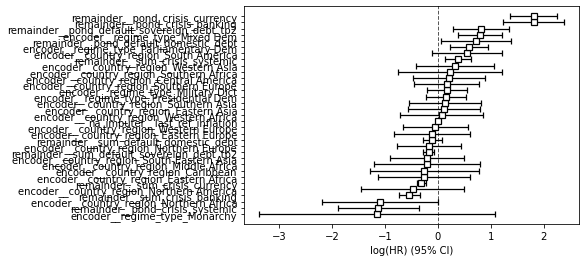

In [274]:
cph.plot()

In [275]:
cph.print_summary()

/home/marcel/repos/survival-regimes/.venv/lib/python3.8/site-packages/lifelines/utils/printer.py:62: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return summary_df[columns].to_latex(float_format="%." + str(self.decimals) + "f")


<lifelines.CoxPHFitter: fitted with 690 total observations, 54 right-censored observations>
             duration col = 'remainder__gov_duration'
                event col = 'remainder__gov_observed_death'
      baseline estimation = breslow
   number of observations = 690
number of events observed = 636
   partial log-likelihood = -3318.33
         time fit was run = 2022-05-22 19:38:34 UTC

---
                                             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                          
encoder__country_region_Caribbean           -0.25       0.78       0.53            -1.29             0.78                 0.28                 2.18
encoder__country_region_Central America      0.21       1.24       0.35            -0.47             0.89                 0.63                 2.45
encoder__country_region_Eastern Africa      -0.27       0.77       0.45            -1.14             0.61                 0.32                 1.84
encoder__country_region_Eastern Asia         0.11       1.12       0.35            -0.56             0.79                 0.57                 2.21
encoder__country_region_Eastern Europe      -0.10       0.90       0.37            -0.82             0.62                 0.44                 1.85
encoder__country_region_Middle Africa       -0.21       0.81       0.51            -1.22             0.79                 0.30                 2.21
encoder__country_region_Northern Africa     -1.09       0.34       0.56            -2.19             0.01                 0.11                 1.01
encoder__country_region_Northern America    -0.48       0.62       0.50            -1.45             0.49                 0.23                 1.64
encoder__country_region_Northern Europe     -0.17       0.85       0.31            -0.78             0.44                 0.46                 1.55
encoder__country_region_South America        0.55       1.74       0.34            -0.12             1.22                 0.89                 3.40
encoder__country_region_South-Eastern Asia  -0.21       0.81       0.35            -0.90             0.49                 0.41                 1.63
encoder__country_region_Southern Africa      0.23       1.26       0.50            -0.76             1.22                 0.47                 3.39
encoder__country_region_Southern Asia        0.14       1.15       0.35            -0.55             0.82                 0.58                 2.28
encoder__country_region_Southern Europe      0.17       1.18       0.32            -0.45             0.79                 0.64                 2.20
encoder__country_region_Western Africa       0.08       1.08       0.40            -0.71             0.86                 0.49                 2.37
encoder__country_region_Western Asia         0.33       1.39       0.38            -0.42             1.07                 0.66                 2.91
encoder__country_region_Western Europe      -0.05       0.95       0.31            -0.66             0.57                 0.52                 1.77
encoder__regime_type_Military Dict           0.17       1.18       0.19            -0.21             0.54                 0.81                 1.72
encoder__regime_type_Mixed Dem               0.80       2.22       0.21             0.39             1.21                 1.48                 3.35
encoder__regime_type_Monarchy               -1.15       0.32       1.14            -3.37             1.08                 0.03                 2.95
encoder__regime_type_Parliamentary Dem       0.58       1.79       0.19             0.22             0.95                 1.25                 2.58
encoder__regime_type_Presidential Dem        0.16       1.17       0.20            -0.23             0.54                 0.80                 1.71
na_imputer__last_ref_inflation               0.0

In [276]:
cph.score(X_test, scoring_method="concordance_index")

0.801473654942305

### Modelo 2

In [287]:
cols_to_use = [
        "country_continent", "regime_type", 'sum_crisis_banking',
       'sum_crisis_systemic', 'sum_default_domestic_debt',
       'sum_default_sovereign_debt_tp2', 'sum_crisis_currency',
       'pond_crisis_banking', 'pond_crisis_systemic',
       'pond_default_domestic_debt', 'pond_default_sovereign_debt_tp2',
       'pond_crisis_currency', 'gov_observed_death', 'gov_duration'
]

X_train, X_test = convert_dfs(joined_df, cols_to_use)

In [288]:
cph = CoxPHFitter()
cph.fit(X_train, event_col="remainder__gov_observed_death", duration_col="remainder__gov_duration")

/home/marcel/repos/survival-regimes/.venv/lib/python3.8/site-packages/lifelines/utils/__init__.py:1188: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)


<lifelines.CoxPHFitter: fitted with 690 total observations, 53 right-censored observations>

<AxesSubplot:xlabel='log(HR) (95% CI)'>

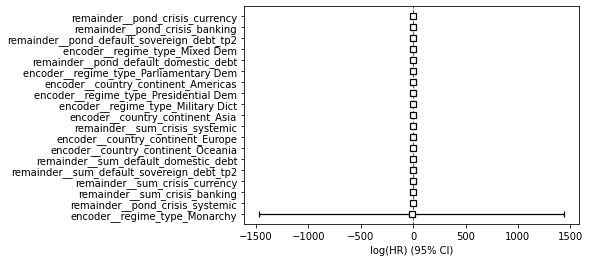

In [289]:
cph.plot()

In [290]:
cph.print_summary()

/home/marcel/repos/survival-regimes/.venv/lib/python3.8/site-packages/lifelines/utils/printer.py:62: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return summary_df[columns].to_latex(float_format="%." + str(self.decimals) + "f")


<lifelines.CoxPHFitter: fitted with 690 total observations, 53 right-censored observations>
             duration col = 'remainder__gov_duration'
                event col = 'remainder__gov_observed_death'
      baseline estimation = breslow
   number of observations = 690
number of events observed = 637
   partial log-likelihood = -3335.64
         time fit was run = 2022-05-22 19:41:22 UTC

---
                                             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                          
encoder__country_continent_Americas          0.39       1.48       0.18             0.03             0.75                 1.03                 2.12
encoder__country_continent_Asia              0.21       1.23       0.19            -0.17             0.59                 0.84                 1.80
encoder__country_continent_Europe            0.12       1.13       0.20            -0.26             0.51                 0.77                 1.66
encoder__country_continent_Oceania          -0.08       0.92       0.32            -0.70             0.54                 0.50                 1.72
encoder__regime_type_Military Dict           0.23       1.26       0.17            -0.11             0.57                 0.90                 1.77
encoder__regime_type_Mixed Dem               0.66       1.94       0.19             0.29             1.04                 1.33                 2.82
encoder__regime_type_Monarchy              -14.80       0.00     741.29         -1467.70          1438.10                 0.00                  inf
encoder__regime_type_Parliamentary Dem       0.50       1.65       0.16             0.19             0.81                 1.21                 2.25
encoder__regime_type_Presidential Dem        0.26       1.30       0.17            -0.08             0.60                 0.93                 1.82
remainder__sum_crisis_banking               -0.44       0.64       0.09            -0.62            -0.26                 0.54                 0.77
remainder__sum_crisis_systemic               0.19       1.21       0.11            -0.03             0.41                 0.97                 1.51
remainder__sum_default_domestic_debt        -0.14       0.87       0.08            -0.30             0.01                 0.74                 1.01
remainder__sum_default_sovereign_debt_tp2   -0.18       0.84       0.05            -0.27            -0.08                 0.76                 0.92
remainder__sum_crisis_currency              -0.23       0.80       0.04            -0.30            -0.16                 0.74                 0.86
remainder__pond_crisis_banking               1.58       4.87       0.27             1.06             2.11                 2.88                 8.21
remainder__pond_crisis_systemic             -0.70       0.50       0.35            -1.38            -0.02                 0.25                 0.98
remainder__pond_default_domestic_debt        0.66       1.93       0.30             0.07             1.24                 1.07                 3.47
remainder__pond_default_sovereign_debt_tp2   0.94       2.57       0.24             0.48             1.41                 1.61                 4.10
remainder__pond_crisis_currency              1.80       6.03       0.21             1.39             2.21                 4.00                 9.09

                                             cmp to     z      p   -log2(p)
covariate                                                                  
encoder__country_continent_Americas            0.00  2.12   0.03       4.86
encoder__country_continent_Asia                0.00  1.08   0.28       1.83
encoder__country_continent_Europe              0.00  0.63   0.53       0.92
encoder__country_continent_Oceania             0.00 -0.25   0.80       0.32
encoder__regime_type_Military Dict 

In [291]:
cph.score(X_test, scoring_method="concordance_index")

0.7899366643209008